In [2]:
import os
import functools as ftools
import itertools as itools
import pandas as pd
import numpy as np

import sgml, dproc, sgnn, sgutil
import tensorflow as tf
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import dill

import seaborn as sns
import matplotlib.pyplot as plt

2024-11-19 09:09:25.203680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732007365.215204  147955 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732007365.218754  147955 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 09:09:25.230819: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from sklearn.model_selection import StratifiedKFold, ShuffleSplit
from sklearn.metrics import accuracy_score

In [209]:
with open(os.path.join('data', 'var_w.dill'), 'rb') as f:
    df_var = dill.load(f)
df_train = pd.read_feather(os.path.join('data', 'train_w.feather'))
sc = sgutil.SGCache('img', 'result')
skf = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
ss = ShuffleSplit(n_splits=1, train_size=0.8, random_state=123)
target = 'Depression'

In [210]:
def get_validation_splitter(validation_fraction):
    return lambda x: train_test_split(x, test_size=validation_fraction, stratify=x[target])

def print_metrics(title, m):
    print("Accuracy, {}: {:.5f}±{:.5f}".format(
        title, np.mean(m), np.std(m)
    ))

config = {
    'predict_func': lambda m, df, X: pd.Series(m.predict_proba(df[X])[:, 1], index=df.index),
    'score_func': lambda df, prds: accuracy_score(df[target].sort_index(), prds.sort_index() > 0.5),
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(),
    'y': target,
}

lgb_adapter = sgml.LGBMAdapter(model=lgb.LGBMClassifier)
xgb_adapter = sgml.XGBAdapter(model=xgb.XGBClassifier)
cb_adapter = sgml.CBAdapter(model=cb.CatBoostClassifier)

def show_result_lgb(result):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    sns.barplot(
        pd.concat([i['feature_importance'] for i in result['model_result']], axis=1).mean(axis=1)\
        .sort_values(ascending=False).rename('Importance').reset_index().rename(columns={'index':'feature'}),
        x = 'Importance', y = 'feature', ax=axes[0]
    )
    valid_result = pd.concat([i['valid_result'] for i in result['model_result']], axis=1).T.groupby(level=1).mean().T
    sns.lineplot(valid_result, ax=axes[1])
    if 'valid_1' in valid_result:
        axes[1].axvline(valid_result['valid_1'].idxmin())
    plt.tight_layout()
    plt.show()

# LGB1

In [211]:
cv_path = os.path.join('result', 'LGB1.cv')
if os.path.exists(cv_path):
    lgb1 = sgml.CVModel.load('result', 'LGB1')
else:
    lgb1 = sgml.CVModel('result', 'LGB1', skf, config, lgb_adapter)

In [214]:
hparams = {
    'model_params': {
        'n_estimators': 2000, 
        'num_leaves': 15,
        'learning_rate': 0.02,
        'random_state' : 123,
        'colsample_bytree' : 0.7,
        'min_child_samples': 4096
    }, 
    'X_tgt': ['Name_R', 'City_R', 'Prof_Degree', 'WS_Degree', 'Profession_R2', 'Degree_R', 'WS_Suicidal'],
    'X_num': ['CGPA', 'Pressure', 'Satisfaction', 'Work/Study Hours', 'Work Pressure', 'Academic Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Age', 'Financial Stress', 'Financial Stress_Age'],
    'X_cat': ['Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Gender', 'Family History of Mental Illness', 'Sleep Duration_R', 'Dietary Habits_R']
}
# result = lgb1.adhoc(df_train, ss, hparams)
# show_result_lgb(result)
# print(result['valid_scores'])

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

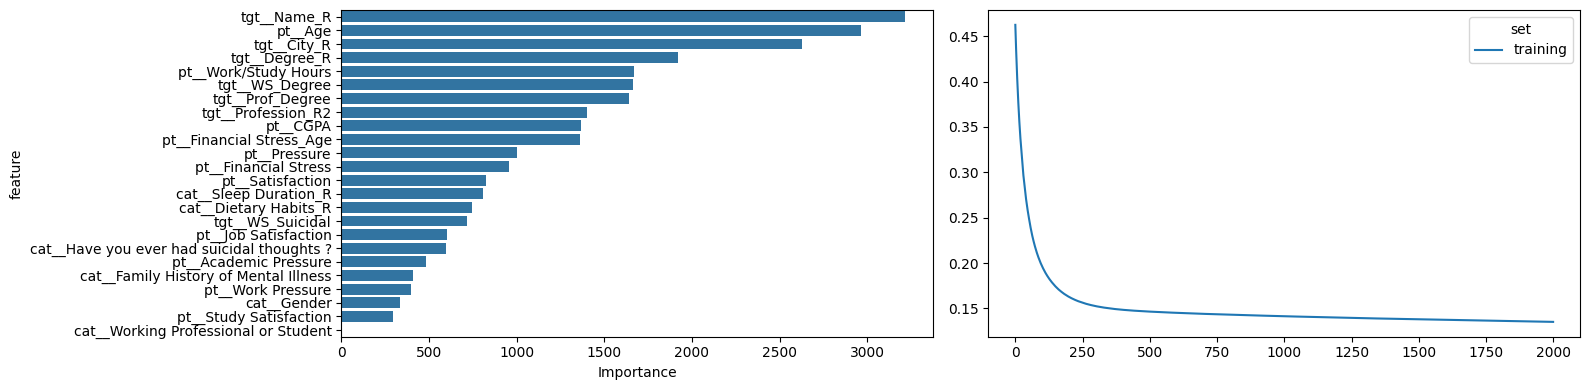

Accuracy, Valid.: 0.93972±0.00141


In [215]:
result = lgb1.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

,value
model_params,"{'n_estimators': 2000, 'num_leaves': 15, 'learning_rate': 0.02, 'random_state': 123, 'colsample_bytree': 0.7, 'min_child_samples': 4096}"
X_tgt,"[Name_R, City_R, Prof_Degree, WS_Degree, Profession_R2, Degree_R, WS_Suicidal]"
X_num,"[CGPA, Pressure, Satisfaction, Work/Study Hours, Work Pressure, Academic Pressure, Study Satisfaction, Job Satisfaction, Age, Financial Stress, Financial Stress_Age]"
X_cat,"[Working Professional or Student, Have you ever had suicidal thoughts ?, Gender, Family History of Mental Illness, Sleep Duration_R, Dietary Habits_R]"


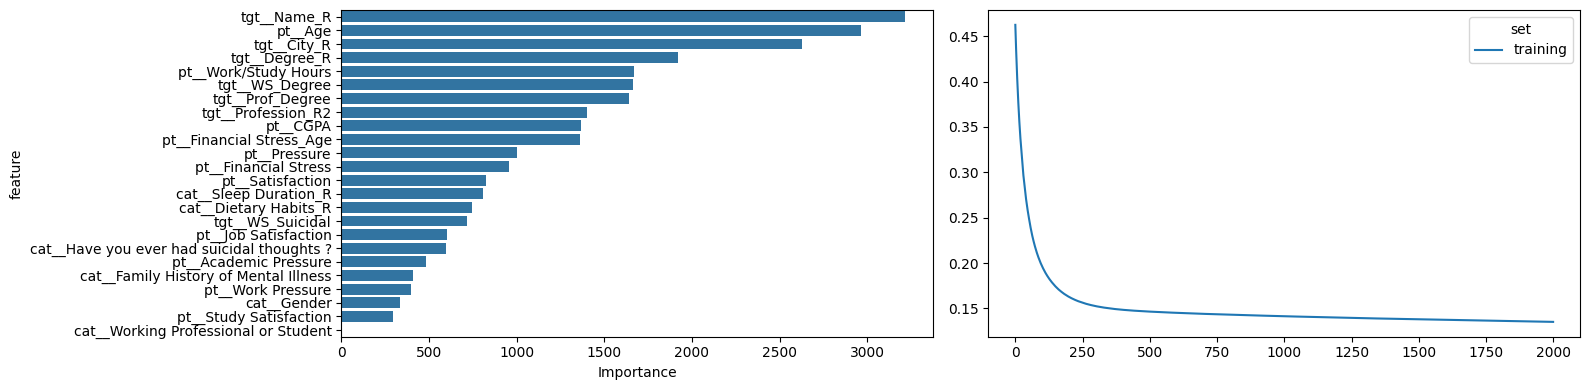

0.9397157071783937


In [216]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(lgb1.cv_best_['hparams']).rename('value').to_frame())
show_result_lgb(lgb1.get_best_result())
print(lgb1.cv_best_['score'])

# XGB1

In [10]:
cv_path = os.path.join('result', 'XGB1.cv')
if os.path.exists(cv_path):
    xgb1 = sgml.CVModel.load('result', 'XGB1')
else:
    xgb1 = sgml.CVModel('result', 'XGB1', skf, config, xgb_adapter)

In [220]:
hparams = {
    'model_params': {
        'n_estimators': 2000, 
        'max_depth': 3,
        'learning_rate': 0.02,
        'random_state' : 123,
        'colsample_bytree' : 0.25,
    }, 
    'X_tgt': ['Name_R', 'City_R', 'Prof_Degree', 'WS_Degree', 'Profession_R2', 'Degree_R', 'WS_Suicidal'],
    'X_num': ['CGPA', 'Pressure', 'Satisfaction', 'Work/Study Hours', 'Work Pressure', 'Academic Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Age', 'Financial Stress', 'Financial Stress_Age'],
    'X_cat': ['Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Gender', 'Family History of Mental Illness', 'Sleep Duration_R', 'Dietary Habits_R'],
    'ohe': {'drop': 'if_binary'}
}
# xgb1.adhoc(df_train, ss, hparams)

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

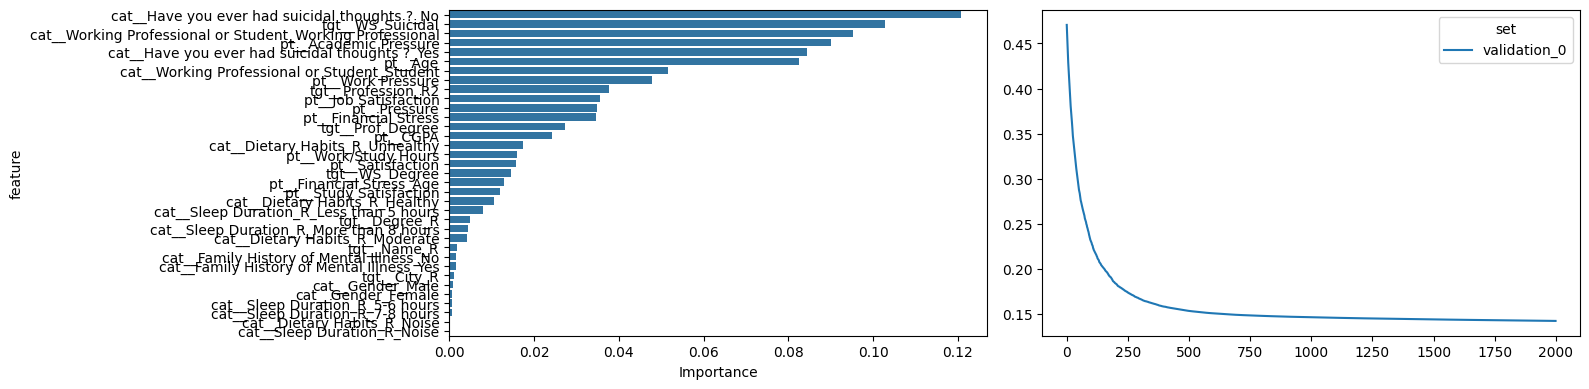

Accuracy, Valid.: 0.93984±0.00165


In [221]:
result = xgb1.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

,value
model_params,"{'n_estimators': 2000, 'max_depth': 3, 'learning_rate': 0.02, 'random_state': 123, 'colsample_bytree': 0.25}"
X_tgt,"[Name_R, City_R, Prof_Degree, WS_Degree, Profession_R2, Degree_R, WS_Suicidal]"
X_num,"[CGPA, Pressure, Satisfaction, Work/Study Hours, Work Pressure, Academic Pressure, Study Satisfaction, Job Satisfaction, Age, Financial Stress, Financial Stress_Age]"
X_cat,"[Working Professional or Student, Have you ever had suicidal thoughts ?, Gender, Family History of Mental Illness, Sleep Duration_R, Dietary Habits_R]"
ohe,{'drop': 'if_binary'}


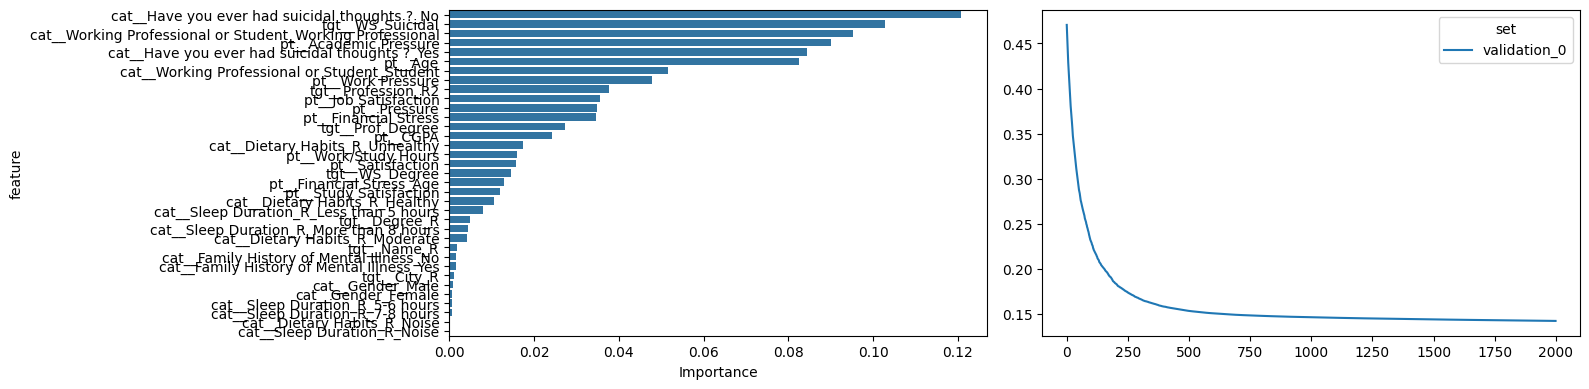

0.9398365316275765


In [222]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(xgb1.cv_best_['hparams']).rename('value').to_frame())
show_result_lgb(xgb1.get_best_result())
print(xgb1.cv_best_['score'])

# CB

In [223]:
cv_path = os.path.join('result', 'CB1.cv')
if os.path.exists(cv_path):
    cb1 = sgml.CVModel.load('result', 'CB1')
else:
    cb1 = sgml.CVModel('result', 'CB1', skf, config, cb_adapter)

In [227]:
hparams = {
    'model_params': {
        'n_estimators': 2000, 
        'max_depth': 5,
        'learning_rate': 0.05,
        'random_state' : 123,
        'rsm': 0.5
    }, 
    'X_num': ['CGPA', 'Pressure', 'Satisfaction', 'Work/Study Hours', 'Work Pressure', 'Academic Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Age', 'Financial Stress', 'Financial Stress_Age'],
    'X_cat': ['Name_R', 'City_R', 'Profession_R2', 'Degree_R',
              'Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Gender', 'Family History of Mental Illness', 'Sleep Duration_R', 'Dietary Habits_R']
}
# cb1.adhoc(df_train, ss, hparams)

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

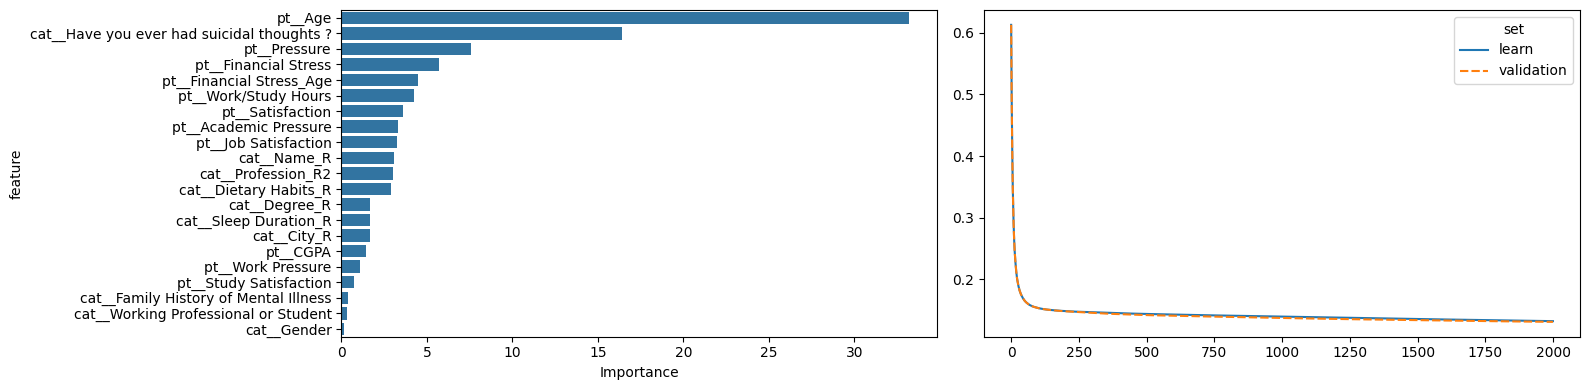

Accuracy, Valid.: 0.94046±0.00173


In [228]:
result = cb1.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

,value
model_params,"{'n_estimators': 2000, 'max_depth': 5, 'learning_rate': 0.05, 'random_state': 123, 'rsm': 0.5}"
X_num,"[CGPA, Pressure, Satisfaction, Work/Study Hours, Work Pressure, Academic Pressure, Study Satisfaction, Job Satisfaction, Age, Financial Stress, Financial Stress_Age]"
X_cat,"[Name_R, City_R, Profession_R2, Degree_R, Working Professional or Student, Have you ever had suicidal thoughts ?, Gender, Family History of Mental Illness, Sleep Duration_R, Dietary Habits_R]"


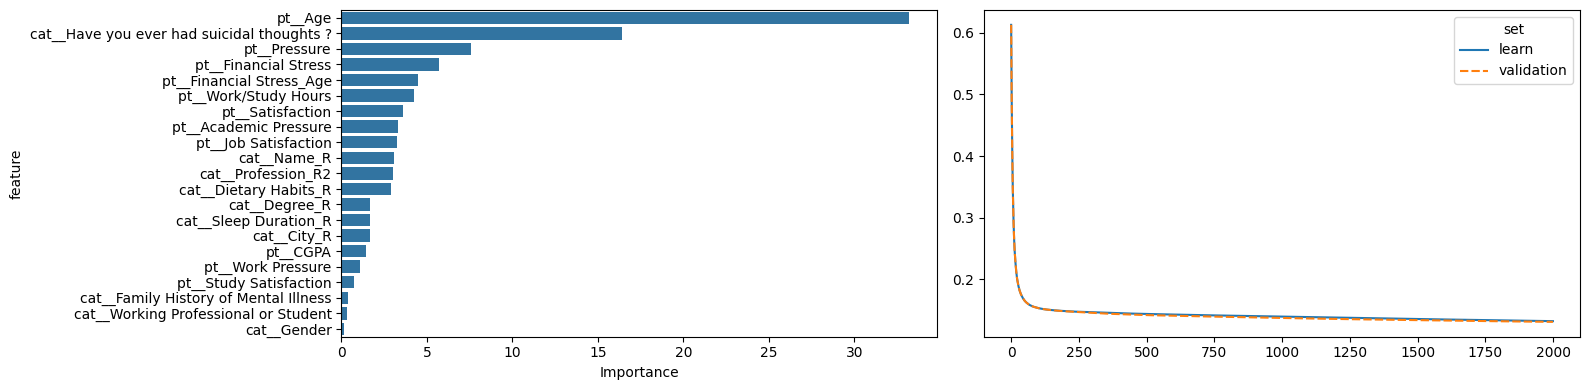

0.9404619758351102


In [229]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(cb1.cv_best_['hparams']).rename('value').to_frame())
show_result_lgb(cb1.get_best_result())
print(cb1.cv_best_['score'])

# NN

In [230]:
class DepressionModel(tf.keras.Model):
    def __init__(self, emb_cols, cont_cols, f_size, left_layers, right_layers, top_layers):
        super().__init__()
        if emb_cols != None:
            self.emb_layers = {
                v.replace(' ', '_').replace('?', '_'): tf.keras.layers.Embedding(c, s, name=v.replace(' ', '_').replace('?', '_')) for v, c, s in emb_cols
            }
            self.emb_cc = tf.keras.layers.Concatenate(axis=-1)
            if left_layers != None:
                self.left_model = tf.keras.models.Sequential([
                    tf.keras.layers.Dropout(**params) if 'rate' in params else tf.keras.layers.Dense(**params) for params in left_layers
                ])
                self.right_model = tf.keras.models.Sequential([
                    tf.keras.layers.Dropout(**params) if 'rate' in params else tf.keras.layers.Dense(**params) for params in right_layers
                ])
                self.mul = tf.keras.layers.Multiply()
                self.left_slice_layer_1 = tf.keras.layers.Lambda(lambda x: x[:, :f_size])
                self.left_slice_layer_2 = tf.keras.layers.Lambda(lambda x: x[:, f_size:])
                self.right_slice_layer_1 = tf.keras.layers.Lambda(lambda x: x[:, :f_size])
                self.right_slice_layer_2 = tf.keras.layers.Lambda(lambda x: x[:, f_size:])
            else:
                self.left_model = None
        else:
            self.emb_layers = None
        self.top_cc = tf.keras.layers.Concatenate(axis=-1)
        self.top_model = tf.keras.models.Sequential([
            tf.keras.layers.Dropout(**params) if 'rate' in params else tf.keras.layers.Dense(**params) for params in top_layers
        ])
        self.f_size = f_size
        self.cont_cols = cont_cols
        self.sigmoid = tf.keras.layers.Activation('sigmoid')

    def __call__(self, X):
        if self.emb_layers != None:
            X_emb = self.emb_cc([tf.squeeze(v(X[k]), axis=-2) for k, v in self.emb_layers.items()])
            if self.left_model !=None:
                X_left = self.left_model(X_emb)
                X_right = self.right_model(X_emb)
                X_left_1 = self.left_slice_layer_1(X_left)
                X_left_2 = self.left_slice_layer_2(X_left)
                
                X_right_1 = self.right_slice_layer_1(X_right)
                X_right_2 = self.right_slice_layer_2(X_right)
                X_mul = self.mul([X_left_1, X_right_1])
                cc_list = [X_left_2, X_right_2, X_mul]
            else:
                cc_list = [X_emb]
        else:
            cc_list = list()
        if self.cont_cols != None:
            cc_list.append(X[self.cont_cols])
        if len(cc_list) == 1:
            return self.sigmoid(
                self.top_model(cc_list[0])
            )
        else:
            return self.sigmoid(
                self.top_model(self.top_cc(cc_list))
            )

def to_tf_dataset(X, Y=None, sample_weights=None, cont=[], cat=[]):
    d = {}
    c = 0
    for i in cat:
        d[i.replace(' ', '_').replace('?', '_')] = np.expand_dims(X[:, c].astype('int'), axis=-1)
        c += 1
        
    if len(cont) > 0:
        d['Continous'] =  X[:, c:]
    if Y is None:
        return tf.data.Dataset.from_tensor_slices(d)
    else:
        if type(Y) == pd.Series:
            if sample_weights is None:
                return tf.data.Dataset.from_tensor_slices((d, Y.values))
            else:
                return tf.data.Dataset.from_tensor_slices((d, Y.values, sample_weights.values))
        else:
            if sample_weights is None:
                return tf.data.Dataset.from_tensor_slices((d, Y))
            else:
                return tf.data.Dataset.from_tensor_slices((d, Y, sample_weights))

def nn_cat_param(df, name, size):
    return name, len(df[name].cat.categories), size


X_cat = ['Name_R', 'City_R', 'Profession_R2', 'Degree_R', 'Sleep Duration_R', 'Dietary Habits_R', 
         'Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Gender', 'Family History of Mental Illness']
X_num = ['CGPA_FZ', 'Pressure', 'Satisfaction', 'Work/Study Hours', 'Work Pressure_FZ', 'Academic Pressure_FZ', 
         'Study Satisfaction_FZ', 'Job Satisfaction_FZ', 'Age', 'Financial Stress_FM', 'Financial Stress_Age']
X_nn_emb = [
    ('Name_R', 4), ('City_R', 3), ('Profession_R2', 3), ('Degree_R', 3), ('Sleep Duration_R', 2), ('Dietary Habits_R', 2), ('Working Professional or Student', 1), 
    ('Have you ever had suicidal thoughts ?', 1), ('Gender', 1), ('Family History of Mental Illness', 1)
]

nn_adapter = sgnn.NNAdapter(
    model=sgnn.NNClassifier,
    to_tf_dataset = ftools.partial(
        to_tf_dataset, 
        cont=X_num,
        cat=X_cat
    )
)

In [231]:
cv_path = os.path.join('result', 'NN1.cv')
if os.path.exists(cv_path):
    nn1 = sgml.CVModel.load('result', 'NN1')
else:
    nn1 = sgml.CVModel('result', 'NN1', skf, config, nn_adapter)

In [232]:
nn_params = {
    'emb_cols': [
        nn_cat_param(df_train, v, n) for v, n in X_nn_emb
    ], 
    'cont_cols':  'Continous',
    'f_size':  16, 
    'left_layers': [
        {'units': 64, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        #{'units': 32, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        {'units': 32, 'kernel_initializer': 'glorot_uniform'}
    ], 
    'right_layers': [
        {'units': 64, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        #{'units': 32, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        {'units': 16, 'kernel_initializer': 'glorot_uniform'}
    ], 
    'top_layers': [
        {'units': 32, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        {'rate': 0.25},
        {'units': 32, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        {'rate': 0.25},
        {'units': 1, 'kernel_initializer': 'glorot_uniform'}
    ]
}

hparams = {
    'model_params': {
        'model': DepressionModel, 
        'model_params': nn_params,
        'epochs': 20,
        'optimizer': ('Adam', {'learning_rate': 0.0003}),
        'batch_size': 512, 'shuffle_size': 102400,
        'early_stopping': None, 'reduce_lr_on_plateau': None, 'lr_scheduler': None
    }, 
    'X_std': X_num,
    'X_cat': X_cat,
    'ohe': {'drop': 'first'}
}
# nn1.adhoc(df_train, ss, hparams)

In [233]:
result = nn1.cv(df_train, hparams)
print_metrics('Valid.', result['valid_scores'])

Accuracy, Valid.: 0.93929±0.00138


In [234]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(nn1.cv_best_['hparams']).rename('value').to_frame())
print(nn1.cv_best_['score'])

,value
model_params,"{'model': <class '__main__.DepressionModel'>, 'model_params': {'emb_cols': [('Name_R', 218, 4), ('City_R', 31, 3), ('Profession_R2', 38, 3), ('Degree_R', 28, 3), ('Sleep Duration_R', 5, 2), ('Dietary Habits_R', 4, 2), ('Working Professional or Student', 2, 1), ('Have you ever had suicidal thoughts ?', 2, 1), ('Gender', 2, 1), ('Family History of Mental Illness', 2, 1)], 'cont_cols': 'Continous', 'f_size': 16, 'left_layers': [{'units': 64, 'activation': 'relu', 'kernel_initializer': 'he_unifo..."
X_std,"[CGPA_FZ, Pressure, Satisfaction, Work/Study Hours, Work Pressure_FZ, Academic Pressure_FZ, Study Satisfaction_FZ, Job Satisfaction_FZ, Age, Financial Stress_FM, Financial Stress_Age]"
X_cat,"[Name_R, City_R, Profession_R2, Degree_R, Sleep Duration_R, Dietary Habits_R, Working Professional or Student, Have you ever had suicidal thoughts ?, Gender, Family History of Mental Illness]"
ohe,{'drop': 'first'}


0.9392892679459844


# LGB + LDA

In [235]:
cv_path = os.path.join('result', 'LGB_LDA.cv')
if os.path.exists(cv_path):
    lgb_lda = sgml.CVModel.load('result', 'LGB_LDA')
else:
    lgb_lda = sgml.CVModel('result', 'LGB_LDA', skf, config, lgb_adapter)

In [240]:
hparams = {
    'model_params': {
        'n_estimators': 2000, 
        'num_leaves': 7,
        'learning_rate': 0.02,
        'random_state' : 123,
        'colsample_bytree' : 0.9,
        'min_child_samples': 1024
    }, 
    'X_tgt': ['Name_R', 'City_R', 'Prof_Degree', 'WS_Degree', 'Profession_R2', 'Degree_R'],
    'X_num': ['CGPA', 'Pressure', 'Satisfaction', 'Work/Study Hours', 'Work Pressure', 'Academic Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Age', 'Financial Stress', 'Financial Stress_Age'],
    'X_cat': ['Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Gender', 'Family History of Mental Illness', 'Sleep Duration_R', 'Dietary Habits_R'],
    'lda' : {
        'X_mm': ["Pressure", "Satisfaction", "Work/Study Hours", "Age", "Financial Stress_FM"],
        'X_ohe': ['Have you ever had suicidal thoughts ?'],
        'ohe': {'drop': 'first'}
    }
}
# result = lgb_lda.adhoc(df_train, ss, hparams)
# show_result_lgb(result)
# print(result['valid_scores'])

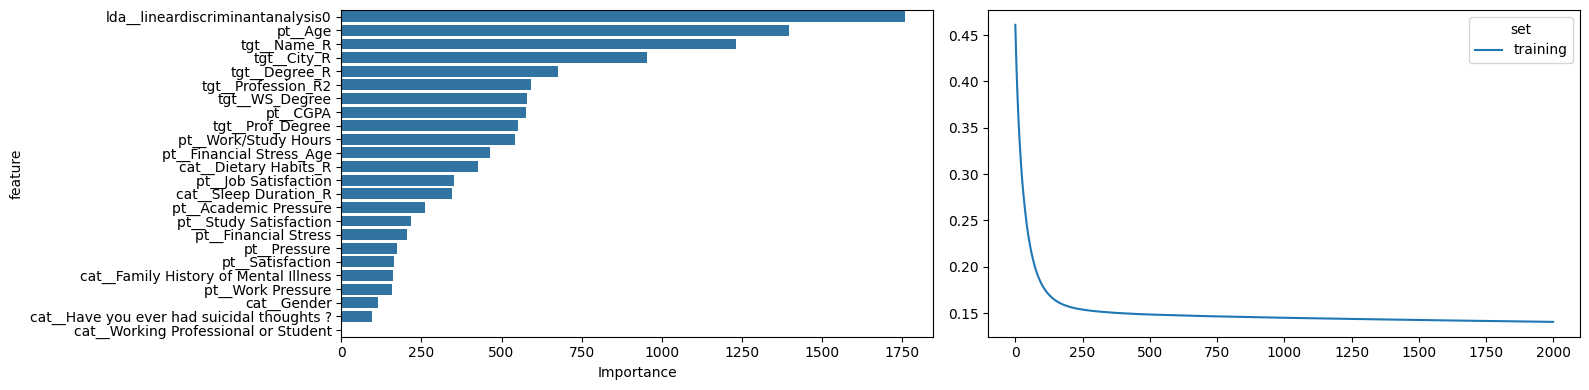

Accuracy, Valid.: 0.93977±0.00156


In [241]:
result = lgb_lda.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

In [242]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(lgb_lda.cv_best_['hparams']).rename('value').to_frame())
print(lgb_lda.cv_best_['score'])

,value
model_params,"{'n_estimators': 2000, 'num_leaves': 7, 'learning_rate': 0.02, 'random_state': 123, 'colsample_bytree': 0.9, 'min_child_samples': 1024}"
X_tgt,"[Name_R, City_R, Prof_Degree, WS_Degree, Profession_R2, Degree_R]"
X_num,"[CGPA, Pressure, Satisfaction, Work/Study Hours, Work Pressure, Academic Pressure, Study Satisfaction, Job Satisfaction, Age, Financial Stress, Financial Stress_Age]"
X_cat,"[Working Professional or Student, Have you ever had suicidal thoughts ?, Gender, Family History of Mental Illness, Sleep Duration_R, Dietary Habits_R]"
lda,"{'X_mm': ['Pressure', 'Satisfaction', 'Work/Study Hours', 'Age', 'Financial Stress_FM'], 'X_ohe': ['Have you ever had suicidal thoughts ?'], 'ohe_drop': 'first'}"


0.9398862828713576


# LGB2

num_leaves를 15 → 7로 낮추어 모델을 구성합니다.

In [243]:
cv_path = os.path.join('result', 'LGB2.cv')
if os.path.exists(cv_path):
    lgb2 = sgml.CVModel.load('result', 'LGB2')
else:
    lgb2 = sgml.CVModel('result', 'LGB2', skf, config, lgb_adapter)

In [247]:
hparams = {
    'model_params': {
        'n_estimators': 2000, 
        'num_leaves': 7,
        'learning_rate': 0.02,
        'random_state' : 123,
        'colsample_bytree' : 0.7,
        'min_child_samples': 2048
    }, 
    'X_tgt': ['Name_R', 'City_R', 'Prof_Degree', 'WS_Degree', 'Profession_R2', 'Degree_R'],
    'X_num': ['CGPA', 'Pressure', 'Satisfaction', 'Work/Study Hours', 'Work Pressure', 'Academic Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Age', 'Financial Stress', 'Financial Stress_Age'],
    'X_cat': ['Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Gender', 'Family History of Mental Illness', 'Sleep Duration_R', 'Dietary Habits_R']
}
# result = lgb2.adhoc(df_train, ss, hparams)
# show_result_lgb(result)
# print(result['valid_scores'])

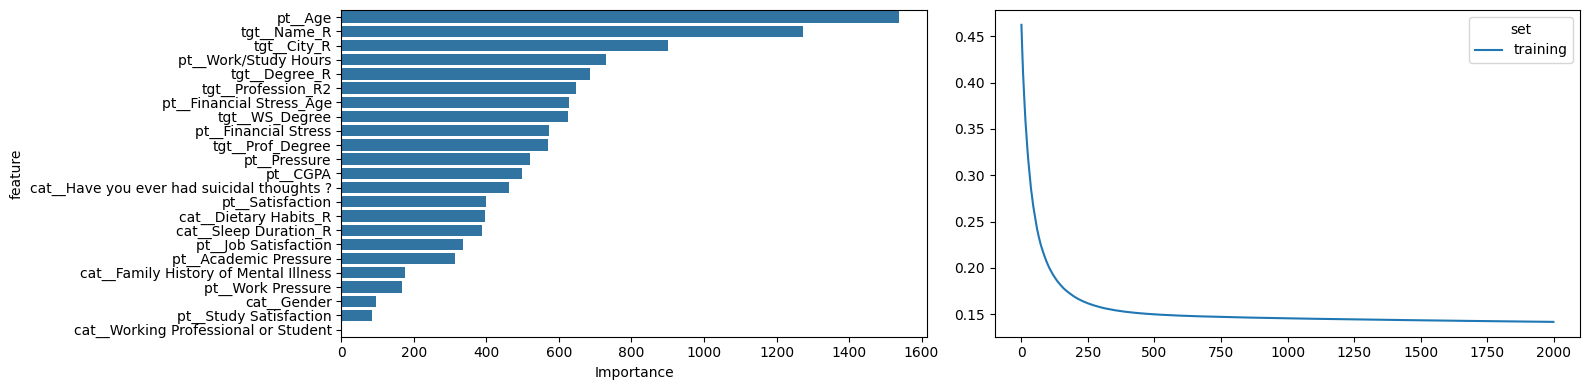

Accuracy, Valid.: 0.93988±0.00123


In [248]:
result = lgb2.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

In [249]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(lgb2.cv_best_['hparams']).rename('value').to_frame())
print(lgb_lda.cv_best_['score'])

,value
model_params,"{'n_estimators': 2000, 'num_leaves': 7, 'learning_rate': 0.02, 'random_state': 123, 'colsample_bytree': 0.7, 'min_child_samples': 2048}"
X_tgt,"[Name_R, City_R, Prof_Degree, WS_Degree, Profession_R2, Degree_R]"
X_num,"[CGPA, Pressure, Satisfaction, Work/Study Hours, Work Pressure, Academic Pressure, Study Satisfaction, Job Satisfaction, Age, Financial Stress, Financial Stress_Age]"
X_cat,"[Working Professional or Student, Have you ever had suicidal thoughts ?, Gender, Family History of Mental Illness, Sleep Duration_R, Dietary Habits_R]"


0.9398862828713576


# XGB + LDA

In [250]:
cv_path = os.path.join('result', 'XGB_LDA.cv')
if os.path.exists(cv_path):
    xgb_lda = sgml.CVModel.load('result', 'XGB_LDA')
else:
    xgb_lda = sgml.CVModel('result', 'XGB_LDA', skf, config, xgb_adapter)

In [276]:
hparams = {
    'model_params': {
        'n_estimators': 2000, 
        'max_depth': 3,
        'learning_rate': 0.03,
        'random_state' : 123,
        'colsample_bytree' : 0.25,
    }, 
    'X_tgt': ['Name_R', 'City_R', 'Prof_Degree', 'WS_Degree', 'Profession_R2', 'Degree_R'],
    'X_num': ['CGPA', 'Pressure', 'Satisfaction', 'Work/Study Hours', 'Work Pressure', 'Academic Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Age', 'Financial Stress', 'Financial Stress_Age'],
    'X_cat': ['Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Gender', 'Family History of Mental Illness', 'Sleep Duration_R', 'Dietary Habits_R'],
    'lda' : {
        'X_mm': ["Pressure", "Satisfaction", "Work/Study Hours", "Age", "Financial Stress_FM"],
        'X_ohe': ['Have you ever had suicidal thoughts ?'],
        'ohe': {'drop': 'first'}
    }, 'ohe': {'drop': 'if_binary'}
}
# result = xgb_lda.adhoc(df_train, ss, hparams)
# show_result_lgb(result)
# print(result['train_scores'], result['valid_scores'])

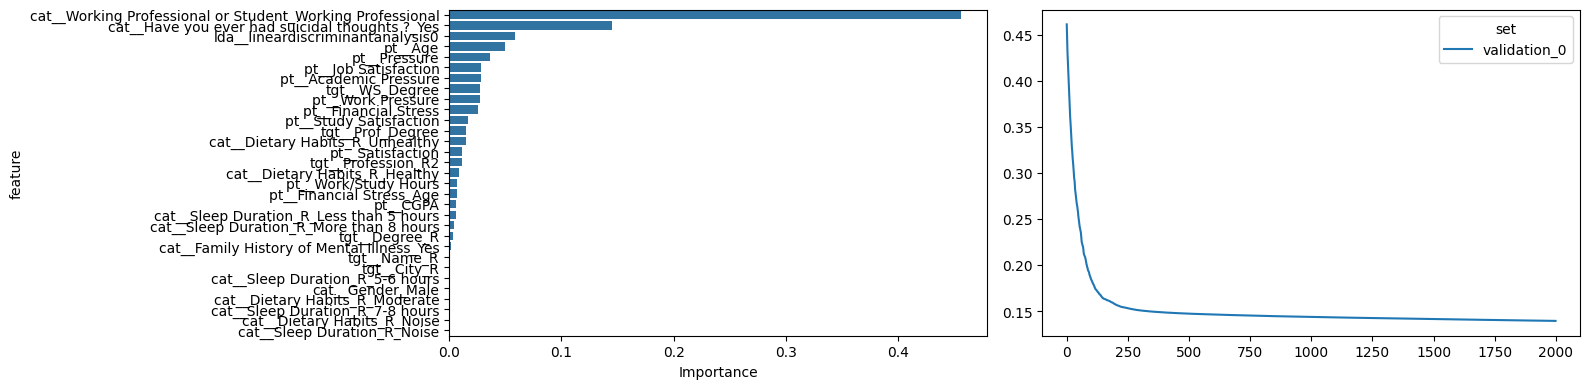

Accuracy, Valid.: 0.94032±0.00153


In [278]:
result = xgb_lda.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

In [279]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(xgb_lda.cv_best_['hparams']).rename('value').to_frame())
print(xgb_lda.cv_best_['score'])

,value
model_params,"{'n_estimators': 2000, 'max_depth': 3, 'learning_rate': 0.03, 'random_state': 123, 'colsample_bytree': 0.25}"
X_tgt,"[Name_R, City_R, Prof_Degree, WS_Degree, Profession_R2, Degree_R]"
X_num,"[CGPA, Pressure, Satisfaction, Work/Study Hours, Work Pressure, Academic Pressure, Study Satisfaction, Job Satisfaction, Age, Financial Stress, Financial Stress_Age]"
X_cat,"[Working Professional or Student, Have you ever had suicidal thoughts ?, Gender, Family History of Mental Illness, Sleep Duration_R, Dietary Habits_R]"
lda,"{'X_mm': ['Pressure', 'Satisfaction', 'Work/Study Hours', 'Age', 'Financial Stress_FM'], 'X_ohe': ['Have you ever had suicidal thoughts ?'], 'ohe': {'drop': 'first'}}"
ohe,{'drop': 'if_binary'}


0.940319829424307


# NN2

In [280]:
cv_path = os.path.join('result', 'NN2.cv')
nn_adapter2 = sgnn.NNAdapter(
    model=sgnn.NNClassifier
)
if os.path.exists(cv_path):
    nn2 = sgml.CVModel.load('result', 'NN2')
else:
    nn2 = sgml.CVModel('result', 'NN2', skf, config, nn_adapter2)

In [281]:
def nn_cat_param(df, name, size):
    return name, len(df[name].cat.categories), size

X_cat = ['Name_R', 'City_R', 'Profession_R2', 'Degree_R', 'Sleep Duration_R', 'Dietary Habits_R', 
         'Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Gender', 'Family History of Mental Illness']
X_num = ['CGPA_FZ', 'Pressure', 'Satisfaction', 'Work/Study Hours', 'Work Pressure_FZ', 'Academic Pressure_FZ', 
         'Study Satisfaction_FZ', 'Job Satisfaction_FZ', 'Age', 'Financial Stress_FM', 'Financial Stress_Age']
X_nn_emb = [
    ('Name_R', 4), ('City_R', 3), ('Profession_R2', 3), ('Degree_R', 3), ('Sleep Duration_R', 2), ('Dietary Habits_R', 2), ('Working Professional or Student', 1), 
    ('Have you ever had suicidal thoughts ?', 1), ('Gender', 1), ('Family History of Mental Illness', 1)
]

nn_params = {
    'embedding':[(1, c, es, 0, 0) for _, c, es in [nn_cat_param(df_train, v, n) for v, n in X_nn_emb]], 
    'config':  [
        {'unit': 64, 'activation': 'relu', 'batch_norm': True},
        {'unit': 32, 'activation': 'relu', 'batch_norm': True, 'dropout': 0.25},
    ]
}

hparams = {
    'model_params': {
        'model_params': nn_params,
        'epochs': 30,
        'optimizer': ('Adam', {'learning_rate': 0.0003}),
        'batch_size': 512, 'shuffle_size': 102400,
        'early_stopping': None, 'reduce_lr_on_plateau': None, 'lr_scheduler': None
    }, 
    'X_std': X_num,
    'X_cat': X_cat,
    'ohe': {'drop': 'first'}
}
# nn2.adhoc(df_train, ss, hparams)

In [282]:
result = nn2.cv(df_train, hparams)
print_metrics('Valid.', result['valid_scores'])

Accuracy, Valid.: 0.93834±0.00119


# CB2

In [283]:
cv_path = os.path.join('result', 'CB2.cv')
if os.path.exists(cv_path):
    cb2 = sgml.CVModel.load('result', 'CB2')
else:
    cb2 = sgml.CVModel('result', 'CB2', skf, config, cb_adapter)

In [289]:
hparams = {
    'model_params': {
        'n_estimators': 2000, 
        'max_depth': 4,
        'learning_rate': 0.07,
        'random_state' : 123,
        'rsm': 0.75,
    }, 
    'X_num': ['CGPA', 'Pressure', 'Satisfaction', 'Work/Study Hours', 'Work Pressure', 'Academic Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Age', 'Financial Stress', 'Financial Stress_Age'],
    'X_cat': ['Name_R', 'City_R', 'Prof_Degree', 'WS_Degree', 'Profession_R2', 'Degree_R',
              'Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Gender', 'Family History of Mental Illness', 'Sleep Duration_R', 'Dietary Habits_R'],
    #'validation_fraction': 0.1
}
#result = cb2.adhoc(df_train, ss, hparams)
#show_result_lgb(result)
#print(result['train_scores'], result['valid_scores'])

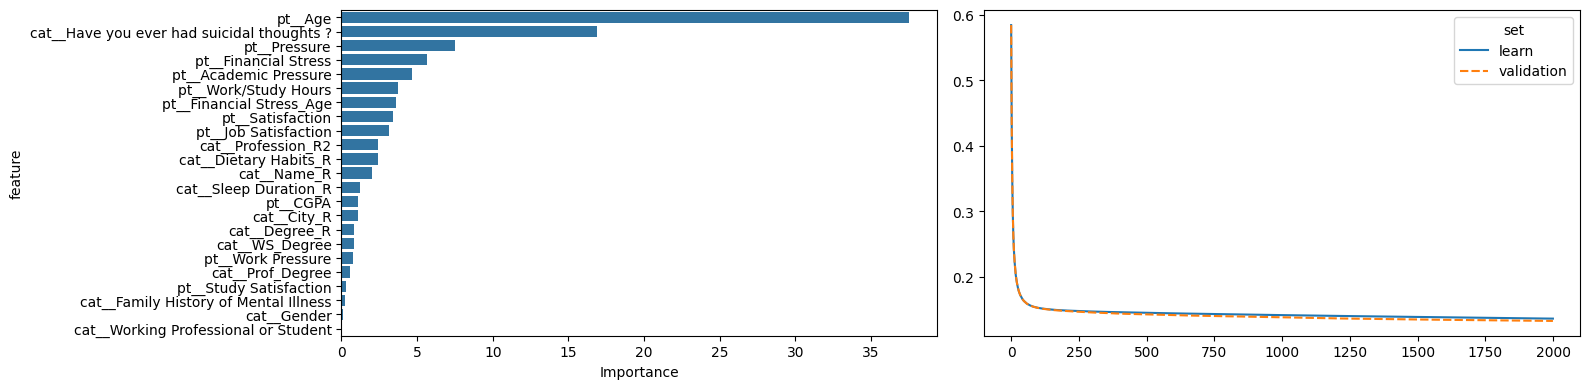

Accuracy, Valid.: 0.94044±0.00178


In [290]:
result = cb2.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

In [291]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(cb2.cv_best_['hparams']).rename('value').to_frame())
print(cb2.cv_best_['score'])

,value
model_params,"{'n_estimators': 2000, 'max_depth': 4, 'learning_rate': 0.07, 'random_state': 123, 'rsm': 0.75}"
X_num,"[CGPA, Pressure, Satisfaction, Work/Study Hours, Work Pressure, Academic Pressure, Study Satisfaction, Job Satisfaction, Age, Financial Stress, Financial Stress_Age]"
X_cat,"[Name_R, City_R, Prof_Degree, WS_Degree, Profession_R2, Degree_R, Working Professional or Student, Have you ever had suicidal thoughts ?, Gender, Family History of Mental Illness, Sleep Duration_R, Dietary Habits_R]"


0.9404406538734896


# CB3

In [292]:
cv_path = os.path.join('result', 'CB3.cv')
if os.path.exists(cv_path):
    cb3 = sgml.CVModel.load('result', 'CB3')
else:
    cb3 = sgml.CVModel('result', 'CB3', skf, config, cb_adapter)

In [293]:
hparams = {
    'model_params': {
        'n_estimators': 1500, 
        'max_depth': 6,
        'learning_rate': 0.05,
        'l2_leaf_reg': 0.7,
        'rsm': 0.25
    }, 
    'X_num': ['CGPA', 'Pressure', 'Satisfaction', 'Work/Study Hours', 'Work Pressure', 'Academic Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Age', 'Financial Stress', 'Financial Stress_Age'],
    'X_cat': ['Name_R', 'City_R', 'Profession_R2', 'Degree_R',
              'Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Gender', 'Family History of Mental Illness', 'Sleep Duration_R', 'Dietary Habits_R'],
    #'validation_fraction': 0.1
}
# cb3.adhoc(df_train, ss, hparams)

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Round:   0%|          | 0/1500 [00:00<?, ?it/s]

Round:   0%|          | 0/1500 [00:00<?, ?it/s]

Round:   0%|          | 0/1500 [00:00<?, ?it/s]

Round:   0%|          | 0/1500 [00:00<?, ?it/s]

Round:   0%|          | 0/1500 [00:00<?, ?it/s]

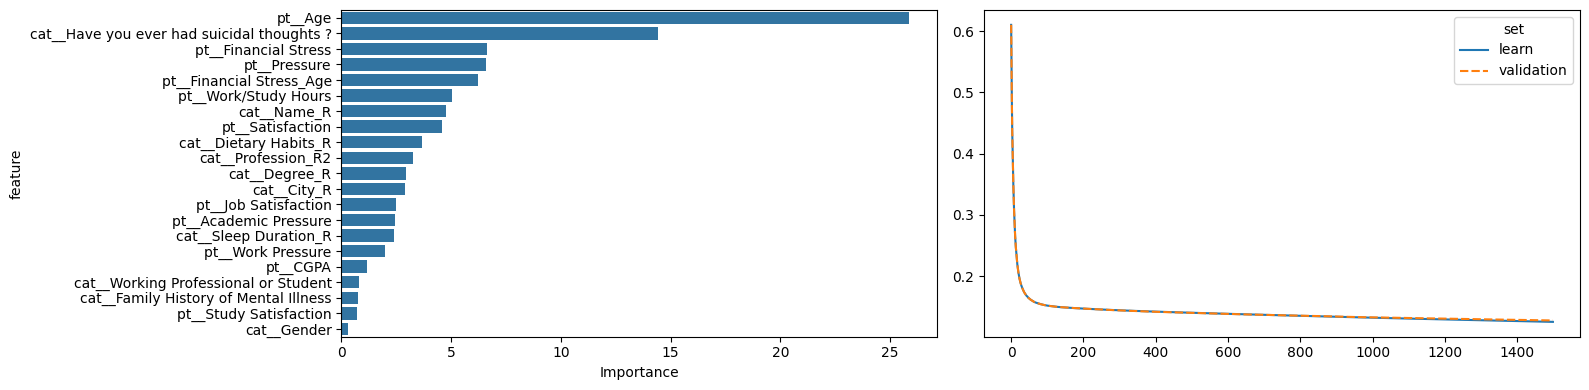

Accuracy, Valid.: 0.94006±0.00157


In [294]:
result = cb3.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

# CB + LDA

In [295]:
cv_path = os.path.join('result', 'CB_LDA.cv')
if os.path.exists(cv_path):
    cb_lda = sgml.CVModel.load('result', 'CB_LDA')
else:
    cb_lda = sgml.CVModel('result', 'CB_LDA', skf, config, cb_adapter)

In [302]:
hparams = {
    'model_params': {
        'n_estimators': 2500, 
        'max_depth': 3,
        'learning_rate': 0.07,
        'random_state' : 123,
    }, 
    'X_num': ['CGPA', 'Pressure', 'Satisfaction', 'Work/Study Hours', 'Work Pressure', 'Academic Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Age', 'Financial Stress', 'Financial Stress_Age'],
    'X_cat': ['Name_R', 'City_R', 'Prof_Degree', 'WS_Degree','Profession_R2', 'Degree_R',
              'Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Gender', 'Family History of Mental Illness', 'Sleep Duration_R', 'Dietary Habits_R'],
    'lda' : {
        'X_mm': ["Pressure", "Satisfaction", "Work/Study Hours", "Age", "Financial Stress_FM"],
        'X_ohe': ['Have you ever had suicidal thoughts ?'],
        'ohe': {'drop': 'first', 'sparse_output': False}
    },
    #'validation_fraction': 0.1
}
"""result = cb_lda.adhoc(df_train, ss, hparams)
show_result_lgb(result)
print(result['train_scores'], result['valid_scores'])
"""

"result = cb_lda.adhoc(df_train, ss, hparams)\nshow_result_lgb(result)\nprint(result['train_scores'], result['valid_scores'])\n"

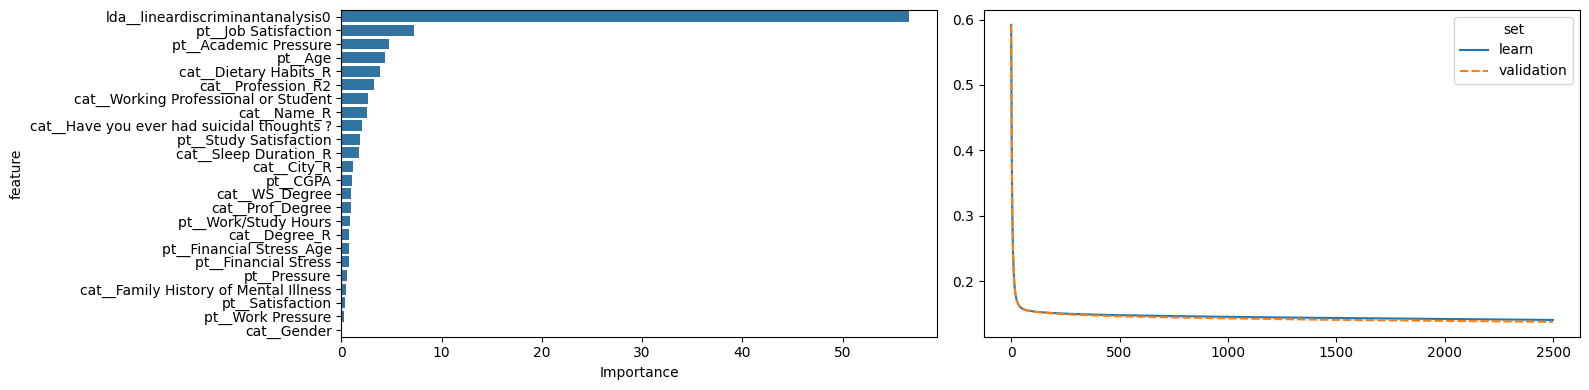

Accuracy, Valid.: 0.94041±0.00172


In [303]:
result = cb_lda.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

In [304]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(cb2.cv_best_['hparams']).rename('value').to_frame())
print(cb2.cv_best_['score'])

,value
model_params,"{'n_estimators': 2000, 'max_depth': 4, 'learning_rate': 0.07, 'random_state': 123, 'rsm': 0.75}"
X_num,"[CGPA, Pressure, Satisfaction, Work/Study Hours, Work Pressure, Academic Pressure, Study Satisfaction, Job Satisfaction, Age, Financial Stress, Financial Stress_Age]"
X_cat,"[Name_R, City_R, Prof_Degree, WS_Degree, Profession_R2, Degree_R, Working Professional or Student, Have you ever had suicidal thoughts ?, Gender, Family History of Mental Illness, Sleep Duration_R, Dietary Habits_R]"


0.9404406538734896


# LGB + LDA + TSVD

In [316]:
cv_path = os.path.join('result', 'LGB_LDA_TSVD.cv')
if os.path.exists(cv_path):
    lgb_lda_tsvd = sgml.CVModel.load('result', 'LGB_LDA_TSVD')
else:
    lgb_lda_tsvd = sgml.CVModel('result', 'LGB_LDA_TSVD', skf, config, lgb_adapter)

In [320]:
hparams = {
    'model_params': {
        'n_estimators': 2000, 
        'num_leaves': 7,
        'learning_rate': 0.02,
        'random_state' : 123,
        'colsample_bytree' : 0.9,
        'min_child_samples': 1024
    }, 
    'X_tgt': ['Name_R', 'City_R', 'Prof_Degree', 'WS_Degree', 'Profession_R2', 'Degree_R'],
    'X_num': ['CGPA', 'Pressure', 'Satisfaction', 'Work/Study Hours', 'Work Pressure', 'Academic Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Age', 'Financial Stress', 'Financial Stress_Age'],
    'X_cat': ['Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Gender', 'Family History of Mental Illness', 'Sleep Duration_R', 'Dietary Habits_R'],
    'lda' : {
        'X_mm': ["Pressure", "Satisfaction", "Work/Study Hours", "Age", "Financial Stress_FM"],
        'X_ohe': ['Have you ever had suicidal thoughts ?'],
        'ohe': {'drop': 'first'}
    },
    'tsvd': {'X_ohe': ['City_R', 'Degree_R', 'Name_R', 'Profession_R2'], 'ohe': {'drop': 'first'}, 'hparams': {'n_components': 10, 'random_state': 123, 'algorithm': 'arpack'}}
}
# result = lgb_lda_tsvd.adhoc(df_train, ss, hparams)
# show_result_lgb(result)
# print(result['valid_scores'])

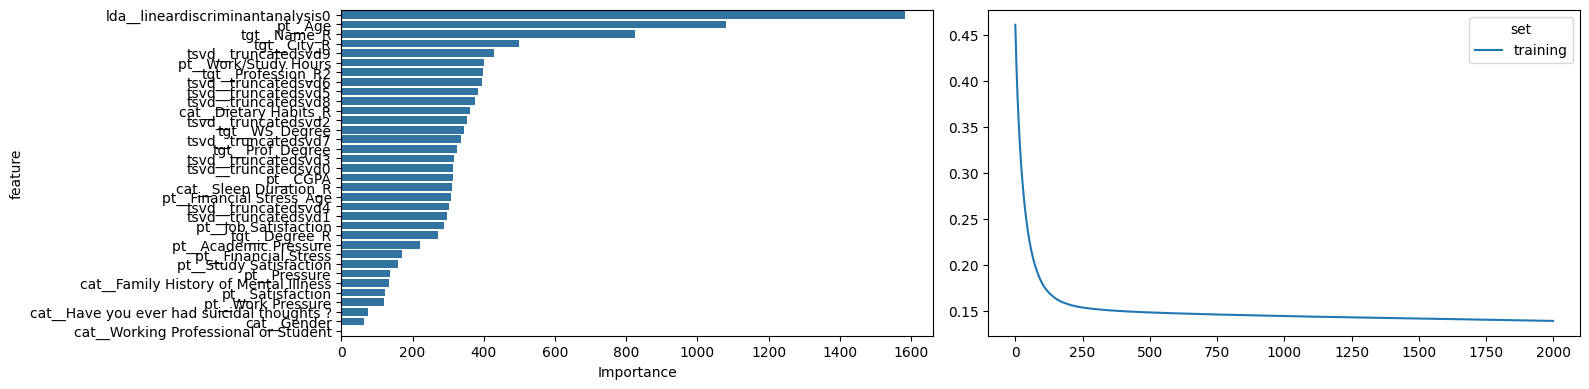

Accuracy, Valid.: 0.93986±0.00181


In [321]:
result = lgb_lda_tsvd.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

In [322]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(lgb_lda_tsvd.cv_best_['hparams']).rename('value').to_frame())
print(lgb_lda_tsvd.cv_best_['score'])

,value
model_params,"{'n_estimators': 2000, 'num_leaves': 7, 'learning_rate': 0.02, 'random_state': 123, 'colsample_bytree': 0.9, 'min_child_samples': 1024}"
X_tgt,"[Name_R, City_R, Prof_Degree, WS_Degree, Profession_R2, Degree_R]"
X_num,"[CGPA, Pressure, Satisfaction, Work/Study Hours, Work Pressure, Academic Pressure, Study Satisfaction, Job Satisfaction, Age, Financial Stress, Financial Stress_Age]"
X_cat,"[Working Professional or Student, Have you ever had suicidal thoughts ?, Gender, Family History of Mental Illness, Sleep Duration_R, Dietary Habits_R]"
lda,"{'X_mm': ['Pressure', 'Satisfaction', 'Work/Study Hours', 'Age', 'Financial Stress_FM'], 'X_ohe': ['Have you ever had suicidal thoughts ?'], 'ohe': {'drop': 'first'}}"
tsvd,"{'X_ohe': ['City_R', 'Degree_R', 'Name_R', 'Profession_R2'], 'ohe': {'drop': 'first'}, 'hparams': {'n_components': 10, 'random_state': 123, 'algorithm': 'arpack'}}"


0.939864960909737


# CB + LDA + TSVD

In [326]:
cv_path = os.path.join('result', 'CB_LDA_TSVD.cv')
if os.path.exists(cv_path):
    cb_lda_tsvd = sgml.CVModel.load('result', 'CB_LDA_TSVD')
else:
    cb_lda_tsvd = sgml.CVModel('result', 'CB_LDA_TSVD', skf, config, cb_adapter)

In [331]:
hparams = {
    'model_params': {
        'n_estimators': 2500, 
        'max_depth': 3,
        'learning_rate': 0.05,
        'random_state' : 123,
    }, 
    'X_num': ['CGPA', 'Pressure', 'Satisfaction', 'Work/Study Hours', 'Work Pressure', 'Academic Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Age', 'Financial Stress', 'Financial Stress_Age'],
    'X_cat': ['Name_R', 'City_R', 'Prof_Degree', 'WS_Degree', 'Profession_R2', 'Degree_R',
              'Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Gender', 'Family History of Mental Illness', 'Sleep Duration_R', 'Dietary Habits_R'],
    'lda' : {
        'X_mm': ["Pressure", "Satisfaction", "Work/Study Hours", "Age", "Financial Stress_FM"],
        'X_ohe': ['Have you ever had suicidal thoughts ?'],
        'ohe': {'drop': 'first', 'sparse_output': False}
    },
    'tsvd': {'X_ohe': ['City_R', 'Degree_R', 'Name_R', 'Profession_R2'], 'ohe': {'drop': 'first', 'sparse_output': False}, 'hparams': {'n_components': 10, 'random_state': 123, 'algorithm': 'arpack'}},
    #'validation_fraction': 0.1
}
# result = cb_lda_tsvd.adhoc(df_train, ss, hparams)
# show_result_lgb(result)
# print(result['train_scores'], result['valid_scores'])

In [ ]:
result = cb_lda_tsvd.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

In [330]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(cb_lda_tsvd.cv_best_['hparams']).rename('value').to_frame())
print(cb_lda_tsvd.cv_best_['score'])

,value
model_params,"{'n_estimators': 2500, 'max_depth': 3, 'learning_rate': 0.03, 'random_state': 123}"
X_num,"[CGPA, Pressure, Satisfaction, Work/Study Hours, Work Pressure, Academic Pressure, Study Satisfaction, Job Satisfaction, Age, Financial Stress, Financial Stress_Age]"
X_cat,"[Name_R, City_R, Prof_Degree, WS_Degree, Profession_R2, Degree_R, Working Professional or Student, Have you ever had suicidal thoughts ?, Gender, Family History of Mental Illness, Sleep Duration_R, Dietary Habits_R]"
lda,"{'X_mm': ['Pressure', 'Satisfaction', 'Work/Study Hours', 'Age', 'Financial Stress_FM'], 'X_ohe': ['Have you ever had suicidal thoughts ?'], 'ohe': {'drop': 'first', 'sparse_output': False}}"
tsvd,"{'X_ohe': ['City_R', 'Degree_R', 'Name_R', 'Profession_R2'], 'ohe': {'drop': 'first', 'sparse_output': False}, 'hparams': {'n_components': 10, 'random_state': 123, 'algorithm': 'arpack'}}"


0.9398791755508172


# XGB + LDA + TSVD

In [333]:
cv_path = os.path.join('result', 'XGB_LDA_TSVD.cv')
if os.path.exists(cv_path):
    xgb_lda_tsvd = sgml.CVModel.load('result', 'XGB_LDA_TSVD')
else:
    xgb_lda_tsvd = sgml.CVModel('result', 'XGB_LDA_TSVD', skf, config, xgb_adapter)

In [335]:
hparams = {
    'model_params': {
        'n_estimators': 2000, 
        'max_depth': 3,
        'learning_rate': 0.03,
        'random_state' : 123,
        'colsample_bytree' : 0.5,
    }, 
    'X_tgt': ['Name_R', 'City_R', 'Prof_Degree', 'WS_Degree', 'Profession_R2', 'Degree_R', 'WS_Suicidal'],
    'X_num': ['CGPA', 'Pressure', 'Satisfaction', 'Work/Study Hours', 'Work Pressure', 'Academic Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Age', 'Financial Stress', 'Financial Stress_Age'],
    'X_cat': ['Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Gender', 'Family History of Mental Illness', 'Sleep Duration_R', 'Dietary Habits_R'],
    'ohe': {'drop': 'if_binary'},
    'lda' : {
        'X_mm': ["Pressure", "Satisfaction", "Work/Study Hours", "Age", "Financial Stress_FM"],
        'X_ohe': ['Have you ever had suicidal thoughts ?'],
        'ohe': {'drop': 'first'}
    },
    'tsvd': {'X_ohe': ['City_R', 'Degree_R', 'Name_R', 'Profession_R2'], 'ohe': {'drop': 'first'}, 'hparams': {'n_components': 10, 'random_state': 123, 'algorithm': 'arpack'}},
}
# result = xgb_lda_tsvd.adhoc(df_train, ss, hparams)
# show_result_lgb(result)
# print(result['train_scores'], result['valid_scores'])

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

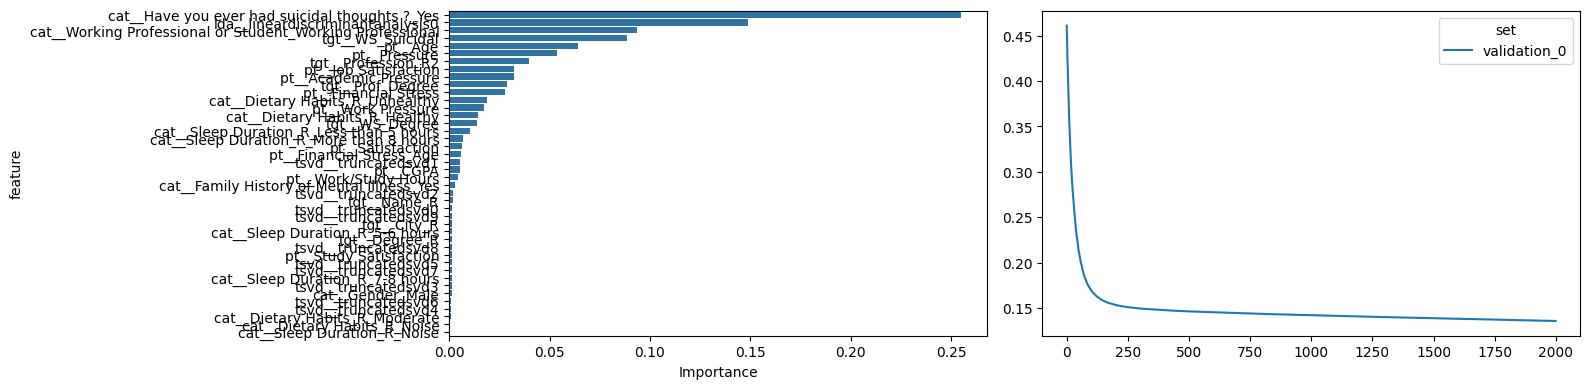

Accuracy, Valid.: 0.93966±0.00199


In [336]:
result = xgb_lda_tsvd.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

# Stacking

In [337]:
models = [lgb1, xgb1, cb1, nn1, lgb_lda, lgb2, xgb_lda, nn2, cb2, cb_lda, cb3, lgb_lda_tsvd, cb_lda_tsvd, xgb_lda_tsvd]

In [339]:
pd.Series([i.cv_best_['score'] for i in models], index=[i.name for i in models]).sort_values(ascending=False).to_frame().T

,CB1,CB2,CB_LDA,XGB_LDA,CB3,LGB_LDA,LGB2,CB_LDA_TSVD,LGB_LDA_TSVD,XGB_LDA_TSVD,XGB1,LGB1,NN1,NN2
0,0.940462,0.940441,0.940412,0.94032,0.940064,0.939886,0.939879,0.939879,0.939865,0.939851,0.939837,0.939716,0.939289,0.939069


In [340]:
df_stk = sgml.stack_cv(models, df_train[target]).sort_index()
df_stk.corr()

,LGB1,XGB1,CB1,NN1,LGB_LDA,LGB2,XGB_LDA,NN2,CB2,CB_LDA,CB3,LGB_LDA_TSVD,CB_LDA_TSVD,XGB_LDA_TSVD,Depression
LGB1,1.000000,0.997279,0.995227,0.988539,0.996395,0.997967,0.996935,0.989297,0.994996,0.994874,0.995180,0.995720,0.994760,0.996081,0.838084
XGB1,0.997279,1.000000,0.996598,0.990551,0.997513,0.998408,0.998484,0.991147,0.996531,0.996426,0.996356,0.996971,0.996780,0.997750,0.838784
CB1,0.995227,0.996598,1.000000,0.990291,0.995643,0.995914,0.996297,0.990950,0.998901,0.997979,0.998427,0.995422,0.996967,0.995999,0.839125
NN1,0.988539,0.990551,0.990291,1.000000,0.990255,0.989672,0.990206,0.995010,0.990309,0.990759,0.989964,0.990632,0.991698,0.990376,0.835603
LGB_LDA,0.996395,0.997513,0.995643,0.990255,1.000000,0.997287,0.997963,0.990944,0.995504,0.996359,0.995403,0.998435,0.996676,0.997276,0.838017
LGB2,0.997967,0.998408,0.995914,0.989672,0.997287,1.000000,0.997804,0.990375,0.995740,0.995783,0.995702,0.996631,0.995965,0.997123,0.838230
XGB_LDA,0.996935,0.998484,0.996297,0.990206,0.997963,0.997804,1.000000,0.990720,0.996220,0.996651,0.996036,0.997400,0.996848,0.998058,0.838533
NN2,0.989297,0.991147,0.990950,0.995010,0.990944,0.990375,0.990720,1.000000,0.990918,0.991308,0.990593,0.991137,0.992012,0.990870,0.835624
CB2,0.994996,0.996531,0.998901,0.990309,0.995504,0.995740,0.996220,0.990918,1.000000,0.998241,0.998043,0.995386,0.997093,0.996015,0.839168
CB_LDA,0.994874,0.996426,0.997979,0.990759,0.996359,0.995783,0.996651,0.991308,0.998241,1.000000,0.997213,0.996267,0.998190,0.996411,0.839114


In [341]:
from sklearn.linear_model import LogisticRegression
lr_adapter = sgml.SklearnAdapter(LogisticRegression)

In [342]:
stk = sgml.CVModel('result', 'stk_lr', skf, config, lr_adapter)

In [343]:
hparams={
    'model_params' : {'C': 10},
    'X_num': ['LGB1', 'CB1', 'NN1', 'XGB_LDA', 'CB2', 'CB_LDA', 'LGB_LDA_TSVD']
}
result = stk.cv(df_stk, hparams)
print_metrics('Valid. score', result['valid_scores'])

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy, Valid. score: 0.94023±0.00150


In [208]:
result#['model_result']

{'valid_scores': [0.937455579246624,
  0.9407604832977967,
  0.9413290689410092,
  0.9412935323383085,
  0.9403695806680882],
 'model_result': [],
 'train_scores': [0.9410181236673774,
  0.9402007818052595,
  0.9398898365316276,
  0.9400408670931059,
  0.9402985074626866]}

In [374]:
accuracy_score(df_stk[target], (df_stk[['LGB2', 'CB1', 'NN1', 'XGB1', 'XGB_LDA', 'CB2', 'CB_LDA', 'CB_LDA_TSVD']].mean(axis=1) > 0.5))

0.9407036247334755

In [376]:
from sklearn.metrics import roc_auc_score
roc_auc_score(df_stk[target], df_stk[['LGB2', 'CB1', 'NN1', 'XGB1', 'XGB_LDA', 'CB2', 'CB_LDA', 'CB_LDA_TSVD']].mean(axis=1))

0.9761443630530137

In [358]:
from sklearn.metrics import roc_auc_score
roc_auc_score(df_stk[target], df_stk[['LGB2', 'CB1', 'NN1', 'XGB1', 'XGB_LDA', 'CB2', 'CB_LDA', 'CB_LDA_TSVD']].mean(axis=1))

0.9761443630530137

In [378]:
accuracy_score(df_stk[target], (df_stk[['CB1', 'NN1', 'CB_LDA']].mean(axis=1) > 0.5))

0.9404832977967307

In [377]:
from sklearn.metrics import roc_auc_score
roc_auc_score(df_stk[target], df_stk[['CB1', 'CB2', 'NN1', 'LGB2']].mean(axis=1))

0.9761437495196941